In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_11/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_11.csv')
print(training_data_df.shape)
training_data_df.head()

(3490574, 310)
Wall time: 34.1 s


,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,(한강)오염행위 제한지역,(한강)폐기물매립시설 설치제한지역,4대문안,가로구역별 최고높이 제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향 검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),소하천,소하천구역,수도공급시설,수평표면구역,시·도 생태·경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생 정화구역,현상변경허가 대상구역,홍수관리구역
0,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.916667,-0.500000,0.866025,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [3]:
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

In [4]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,층
3,건물나이
4,(한강)오염행위 제한지역


In [5]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

290

In [6]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

289

In [7]:
cat_cols

['층',
 '건물나이',
 'trade_type',
 '표준지여부',
 '(한강)오염행위_제한지역',
 '(한강)폐기물매립시설_설치제한지역',
 '4대문안',
 '가로구역별_최고높이_제한지역',
 '가스공급설비',
 '가축사육제한구역',
 '개발제한구역',
 '개발진흥지구',
 '개발행위허가제한지역',
 '건축선',
 '건축용도지역기타',
 '건축용도지역미분류',
 '건축허가_착공제한지역',
 '경관광장',
 '경관녹지',
 '경관지구',
 '경관지구기타',
 '고도지구',
 '고등학교',
 '고속철도',
 '공공공지',
 '공공도서관',
 '공공문화체육시설미분류',
 '공공시설구역',
 '공공주택지구',
 '공공지원민간임대주택_공급촉진지구',
 '공공청사',
 '공동구',
 '공용시설보호지구',
 '공원',
 '공원마을지구(공원집단시설지구)',
 '공원자연보존지구',
 '공원자연환경지구',
 '공익용산지',
 '공익임지',
 '공장설립승인지역',
 '공장설립제한지역',
 '공항소음피해예상지역',
 '공항시설보호지구',
 '과밀억제권역',
 '광로1류(폭_70M_이상)',
 '광로2류(폭_50M~70M)',
 '광로3류(폭_40M~50M)',
 '광역계획구역',
 '광장',
 '교육환경보호구역',
 '교통광장',
 '국가산업단지',
 '국가지정문화재구역',
 '국가하천',
 '국립공원',
 '국민임대주택단지예정지구',
 '국지도로',
 '국토이용기타용도지구',
 '국토이용용도지구기타',
 '근린공원',
 '근린광장',
 '근린상업지역',
 '기타공공공지시설',
 '기타공공청사시설',
 '기타공원시설',
 '기타교통시설',
 '기타녹지시설',
 '기타도로시설',
 '기타도시공간시설',
 '기타문화시설',
 '기타보건위생시설',
 '기타수도시설',
 '기타시장시설',
 '기타용도지역지구기타',
 '기타용지',
 '기타유통업무설비',
 '기타자동차정류장',
 '기타주차장시설',
 '기타철도시설',
 '기타폐기물처리시설',
 '노외주차장',
 '녹지',
 '대공방어

In [8]:
training_data_df.head()

,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.916667,-0.500000,0.866025,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [9]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(698115, 310)
(558492, 310)
(2233967, 310)


In [10]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed']#, 'land_area_log']

In [11]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

(698115, 306)
(698115,)


In [12]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

(558492, 306)
(558492,)


In [13]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

(2233967, 306)
(2233967,)


<AxesSubplot:>

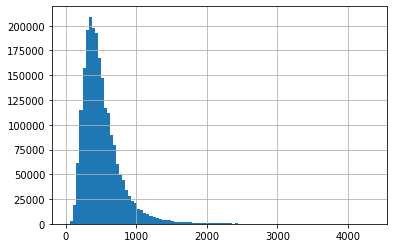

In [14]:
y_train.hist(bins=100)

# Training

In [15]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [16]:
import lightgbm as lgb

In [17]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse'
}

In [18]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [19]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=200, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.405750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4672
[LightGBM] [Info] Number of data points in the train set: 2233967, number of used features: 300


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 508.237811
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 151.64
[100]	valid_0's rmse: 125.058
[150]	valid_0's rmse: 113.632
[200]	valid_0's rmse: 107.289
[250]	valid_0's rmse: 103.192
[300]	valid_0's rmse: 100.159
[350]	valid_0's rmse: 97.7402
[400]	valid_0's rmse: 95.7549
[450]	valid_0's rmse: 94.2016
[500]	valid_0's rmse: 92.8284
[550]	valid_0's rmse: 91.5301
[600]	valid_0's rmse: 90.403
[650]	valid_0's rmse: 89.3799
[700]	valid_0's rmse: 88.4647
[750]	valid_0's rmse: 87.6514
[800]	valid_0's rmse: 86.8905
[850]	valid_0's rmse: 86.2155
[900]	valid_0's rmse: 85.5575
[950]	valid_0's rmse: 84.9429
[1000]	valid_0's rmse: 84.4181
[1050]	valid_0's rmse: 83.8756
[1100]	valid_0's rmse: 83.3377
[1150]	valid_0's rmse: 82.8613
[1200]	valid_0's rmse: 82.4215
[1250]	valid_0's rmse: 81.9915
[1300]	valid_0's rmse: 81.5598
[1350]	valid_0's rmse: 81.1291
[1400]	valid_0's rmse: 80.7742
[1450]	valid_0's rmse: 80.3833
[1500]

[13100]	valid_0's rmse: 61.8743
[13150]	valid_0's rmse: 61.848
[13200]	valid_0's rmse: 61.8256
[13250]	valid_0's rmse: 61.8059
[13300]	valid_0's rmse: 61.7836
[13350]	valid_0's rmse: 61.7607
[13400]	valid_0's rmse: 61.7355
[13450]	valid_0's rmse: 61.715
[13500]	valid_0's rmse: 61.6917
[13550]	valid_0's rmse: 61.6637
[13600]	valid_0's rmse: 61.642
[13650]	valid_0's rmse: 61.6216
[13700]	valid_0's rmse: 61.598
[13750]	valid_0's rmse: 61.5775
[13800]	valid_0's rmse: 61.5567
[13850]	valid_0's rmse: 61.5344
[13900]	valid_0's rmse: 61.5176
[13950]	valid_0's rmse: 61.4973
[14000]	valid_0's rmse: 61.4782
[14050]	valid_0's rmse: 61.4582
[14100]	valid_0's rmse: 61.4347
[14150]	valid_0's rmse: 61.4118
[14200]	valid_0's rmse: 61.391
[14250]	valid_0's rmse: 61.3677
[14300]	valid_0's rmse: 61.3441
[14350]	valid_0's rmse: 61.3263
[14400]	valid_0's rmse: 61.305
[14450]	valid_0's rmse: 61.2816
[14500]	valid_0's rmse: 61.2573
[14550]	valid_0's rmse: 61.2377
[14600]	valid_0's rmse: 61.219
[14650]	valid_0

[26000]	valid_0's rmse: 58.1411
[26050]	valid_0's rmse: 58.1316
[26100]	valid_0's rmse: 58.1223
[26150]	valid_0's rmse: 58.1118
[26200]	valid_0's rmse: 58.1033
[26250]	valid_0's rmse: 58.0916
[26300]	valid_0's rmse: 58.0824
[26350]	valid_0's rmse: 58.0706
[26400]	valid_0's rmse: 58.0595
[26450]	valid_0's rmse: 58.0429
[26500]	valid_0's rmse: 58.0301
[26550]	valid_0's rmse: 58.0198
[26600]	valid_0's rmse: 58.0113
[26650]	valid_0's rmse: 58.0031
[26700]	valid_0's rmse: 57.9937
[26750]	valid_0's rmse: 57.9848
[26800]	valid_0's rmse: 57.9734
[26850]	valid_0's rmse: 57.9627
[26900]	valid_0's rmse: 57.9527
[26950]	valid_0's rmse: 57.9442
[27000]	valid_0's rmse: 57.9361
[27050]	valid_0's rmse: 57.928
[27100]	valid_0's rmse: 57.9219
[27150]	valid_0's rmse: 57.9116
[27200]	valid_0's rmse: 57.902
[27250]	valid_0's rmse: 57.8928
[27300]	valid_0's rmse: 57.8843
[27350]	valid_0's rmse: 57.8768
[27400]	valid_0's rmse: 57.8692
[27450]	valid_0's rmse: 57.8603
[27500]	valid_0's rmse: 57.8529
[27550]	va

[38900]	valid_0's rmse: 56.2712
[38950]	valid_0's rmse: 56.2658
[39000]	valid_0's rmse: 56.2597
[39050]	valid_0's rmse: 56.2538
[39100]	valid_0's rmse: 56.248
[39150]	valid_0's rmse: 56.2408
[39200]	valid_0's rmse: 56.2342
[39250]	valid_0's rmse: 56.2292
[39300]	valid_0's rmse: 56.2224
[39350]	valid_0's rmse: 56.2172
[39400]	valid_0's rmse: 56.2118
[39450]	valid_0's rmse: 56.2062
[39500]	valid_0's rmse: 56.2007
[39550]	valid_0's rmse: 56.1956
[39600]	valid_0's rmse: 56.1893
[39650]	valid_0's rmse: 56.1851
[39700]	valid_0's rmse: 56.1777
[39750]	valid_0's rmse: 56.1707
[39800]	valid_0's rmse: 56.1652
[39850]	valid_0's rmse: 56.1607
[39900]	valid_0's rmse: 56.1548
[39950]	valid_0's rmse: 56.1498
[40000]	valid_0's rmse: 56.1424
[40050]	valid_0's rmse: 56.1367
[40100]	valid_0's rmse: 56.1312
[40150]	valid_0's rmse: 56.1248
[40200]	valid_0's rmse: 56.1199
[40250]	valid_0's rmse: 56.1151
[40300]	valid_0's rmse: 56.1097
[40350]	valid_0's rmse: 56.1064
[40400]	valid_0's rmse: 56.1021
[40450]	v

[51750]	valid_0's rmse: 55.1579
[51800]	valid_0's rmse: 55.1543
[51850]	valid_0's rmse: 55.1519
[51900]	valid_0's rmse: 55.1491
[51950]	valid_0's rmse: 55.1456
[52000]	valid_0's rmse: 55.141
[52050]	valid_0's rmse: 55.1385
[52100]	valid_0's rmse: 55.1352
[52150]	valid_0's rmse: 55.1324
[52200]	valid_0's rmse: 55.1294
[52250]	valid_0's rmse: 55.1267
[52300]	valid_0's rmse: 55.1238
[52350]	valid_0's rmse: 55.1203
[52400]	valid_0's rmse: 55.1178
[52450]	valid_0's rmse: 55.1148
[52500]	valid_0's rmse: 55.1114
[52550]	valid_0's rmse: 55.1081
[52600]	valid_0's rmse: 55.1046
[52650]	valid_0's rmse: 55.1015
[52700]	valid_0's rmse: 55.0981
[52750]	valid_0's rmse: 55.0946
[52800]	valid_0's rmse: 55.091
[52850]	valid_0's rmse: 55.0881
[52900]	valid_0's rmse: 55.085
[52950]	valid_0's rmse: 55.0815
[53000]	valid_0's rmse: 55.0784
[53050]	valid_0's rmse: 55.0752
[53100]	valid_0's rmse: 55.0722
[53150]	valid_0's rmse: 55.0683
[53200]	valid_0's rmse: 55.0652
[53250]	valid_0's rmse: 55.0617
[53300]	val

[64650]	valid_0's rmse: 54.3981
[64700]	valid_0's rmse: 54.3962
[64750]	valid_0's rmse: 54.394
[64800]	valid_0's rmse: 54.3914
[64850]	valid_0's rmse: 54.3898
[64900]	valid_0's rmse: 54.3875
[64950]	valid_0's rmse: 54.3858
[65000]	valid_0's rmse: 54.3838
[65050]	valid_0's rmse: 54.381
[65100]	valid_0's rmse: 54.3778
[65150]	valid_0's rmse: 54.374
[65200]	valid_0's rmse: 54.3714
[65250]	valid_0's rmse: 54.3684
[65300]	valid_0's rmse: 54.3658
[65350]	valid_0's rmse: 54.3636
[65400]	valid_0's rmse: 54.3613
[65450]	valid_0's rmse: 54.3582
[65500]	valid_0's rmse: 54.3555
[65550]	valid_0's rmse: 54.3531
[65600]	valid_0's rmse: 54.3503
[65650]	valid_0's rmse: 54.3476
[65700]	valid_0's rmse: 54.3449
[65750]	valid_0's rmse: 54.3427
[65800]	valid_0's rmse: 54.3399
[65850]	valid_0's rmse: 54.3377
[65900]	valid_0's rmse: 54.3354
[65950]	valid_0's rmse: 54.3319
[66000]	valid_0's rmse: 54.3281
[66050]	valid_0's rmse: 54.325
[66100]	valid_0's rmse: 54.322
[66150]	valid_0's rmse: 54.3194
[66200]	valid

[77550]	valid_0's rmse: 53.8435
[77600]	valid_0's rmse: 53.8425
[77650]	valid_0's rmse: 53.8404
[77700]	valid_0's rmse: 53.8383
[77750]	valid_0's rmse: 53.8363
[77800]	valid_0's rmse: 53.8345
[77850]	valid_0's rmse: 53.833
[77900]	valid_0's rmse: 53.8308
[77950]	valid_0's rmse: 53.8287
[78000]	valid_0's rmse: 53.8262
[78050]	valid_0's rmse: 53.8242
[78100]	valid_0's rmse: 53.8221
[78150]	valid_0's rmse: 53.8208
[78200]	valid_0's rmse: 53.8191
[78250]	valid_0's rmse: 53.8175
[78300]	valid_0's rmse: 53.8157
[78350]	valid_0's rmse: 53.8128
[78400]	valid_0's rmse: 53.8107
[78450]	valid_0's rmse: 53.8084
[78500]	valid_0's rmse: 53.8074
[78550]	valid_0's rmse: 53.8056
[78600]	valid_0's rmse: 53.8032
[78650]	valid_0's rmse: 53.8008
[78700]	valid_0's rmse: 53.7993
[78750]	valid_0's rmse: 53.7975
[78800]	valid_0's rmse: 53.7951
[78850]	valid_0's rmse: 53.7934
[78900]	valid_0's rmse: 53.7922
[78950]	valid_0's rmse: 53.7906
[79000]	valid_0's rmse: 53.7888
[79050]	valid_0's rmse: 53.7875
[79100]	v

[90450]	valid_0's rmse: 53.419
[90500]	valid_0's rmse: 53.4183
[90550]	valid_0's rmse: 53.4177
[90600]	valid_0's rmse: 53.4168
[90650]	valid_0's rmse: 53.4152
[90700]	valid_0's rmse: 53.4135
[90750]	valid_0's rmse: 53.4122
[90800]	valid_0's rmse: 53.4117
[90850]	valid_0's rmse: 53.4104
[90900]	valid_0's rmse: 53.4091
[90950]	valid_0's rmse: 53.4079
[91000]	valid_0's rmse: 53.4061
[91050]	valid_0's rmse: 53.4047
[91100]	valid_0's rmse: 53.4034
[91150]	valid_0's rmse: 53.4018
[91200]	valid_0's rmse: 53.4009
[91250]	valid_0's rmse: 53.3993
[91300]	valid_0's rmse: 53.3979
[91350]	valid_0's rmse: 53.3967
[91400]	valid_0's rmse: 53.3952
[91450]	valid_0's rmse: 53.3932
[91500]	valid_0's rmse: 53.392
[91550]	valid_0's rmse: 53.3906
[91600]	valid_0's rmse: 53.3891
[91650]	valid_0's rmse: 53.3879
[91700]	valid_0's rmse: 53.3866
[91750]	valid_0's rmse: 53.3855
[91800]	valid_0's rmse: 53.3843
[91850]	valid_0's rmse: 53.3828
[91900]	valid_0's rmse: 53.3816
[91950]	valid_0's rmse: 53.3807
[92000]	va

[103200]	valid_0's rmse: 53.1054
[103250]	valid_0's rmse: 53.1046
[103300]	valid_0's rmse: 53.1025
[103350]	valid_0's rmse: 53.1017
[103400]	valid_0's rmse: 53.1011
[103450]	valid_0's rmse: 53.1004
[103500]	valid_0's rmse: 53.0993
[103550]	valid_0's rmse: 53.0976
[103600]	valid_0's rmse: 53.0964
[103650]	valid_0's rmse: 53.0954
[103700]	valid_0's rmse: 53.0938
[103750]	valid_0's rmse: 53.0934
[103800]	valid_0's rmse: 53.0921
[103850]	valid_0's rmse: 53.0912
[103900]	valid_0's rmse: 53.09
[103950]	valid_0's rmse: 53.0884
[104000]	valid_0's rmse: 53.0873
[104050]	valid_0's rmse: 53.0863
[104100]	valid_0's rmse: 53.0853
[104150]	valid_0's rmse: 53.0841
[104200]	valid_0's rmse: 53.0832
[104250]	valid_0's rmse: 53.082
[104300]	valid_0's rmse: 53.0813
[104350]	valid_0's rmse: 53.0804
[104400]	valid_0's rmse: 53.0797
[104450]	valid_0's rmse: 53.0785
[104500]	valid_0's rmse: 53.077
[104550]	valid_0's rmse: 53.0751
[104600]	valid_0's rmse: 53.073
[104650]	valid_0's rmse: 53.0717
[104700]	valid_

[115700]	valid_0's rmse: 52.8637
[115750]	valid_0's rmse: 52.8631
[115800]	valid_0's rmse: 52.8622
[115850]	valid_0's rmse: 52.8612
[115900]	valid_0's rmse: 52.86
[115950]	valid_0's rmse: 52.8589
[116000]	valid_0's rmse: 52.8584
[116050]	valid_0's rmse: 52.8576
[116100]	valid_0's rmse: 52.8573
[116150]	valid_0's rmse: 52.8563
[116200]	valid_0's rmse: 52.8557
[116250]	valid_0's rmse: 52.8549
[116300]	valid_0's rmse: 52.8545
[116350]	valid_0's rmse: 52.8539
[116400]	valid_0's rmse: 52.853
[116450]	valid_0's rmse: 52.8519
[116500]	valid_0's rmse: 52.8511
[116550]	valid_0's rmse: 52.8498
[116600]	valid_0's rmse: 52.8493
[116650]	valid_0's rmse: 52.8487
[116700]	valid_0's rmse: 52.8475
[116750]	valid_0's rmse: 52.847
[116800]	valid_0's rmse: 52.8462
[116850]	valid_0's rmse: 52.8454
[116900]	valid_0's rmse: 52.8444
[116950]	valid_0's rmse: 52.8435
[117000]	valid_0's rmse: 52.8424
[117050]	valid_0's rmse: 52.8411
[117100]	valid_0's rmse: 52.84
[117150]	valid_0's rmse: 52.839
[117200]	valid_0'

[128200]	valid_0's rmse: 52.6683
[128250]	valid_0's rmse: 52.668
[128300]	valid_0's rmse: 52.6673
[128350]	valid_0's rmse: 52.6668
[128400]	valid_0's rmse: 52.6658
[128450]	valid_0's rmse: 52.6654
[128500]	valid_0's rmse: 52.6646
[128550]	valid_0's rmse: 52.6636
[128600]	valid_0's rmse: 52.6625
[128650]	valid_0's rmse: 52.662
[128700]	valid_0's rmse: 52.6612
[128750]	valid_0's rmse: 52.6603
[128800]	valid_0's rmse: 52.6595
[128850]	valid_0's rmse: 52.6586
[128900]	valid_0's rmse: 52.658
[128950]	valid_0's rmse: 52.6573
[129000]	valid_0's rmse: 52.6568
[129050]	valid_0's rmse: 52.6557
[129100]	valid_0's rmse: 52.6547
[129150]	valid_0's rmse: 52.6536
[129200]	valid_0's rmse: 52.6531
[129250]	valid_0's rmse: 52.6526
[129300]	valid_0's rmse: 52.6522
[129350]	valid_0's rmse: 52.6512
[129400]	valid_0's rmse: 52.6508
[129450]	valid_0's rmse: 52.6503
[129500]	valid_0's rmse: 52.6496
[129550]	valid_0's rmse: 52.649
[129600]	valid_0's rmse: 52.6483
[129650]	valid_0's rmse: 52.6478
[129700]	valid

[140650]	valid_0's rmse: 52.5123
[140700]	valid_0's rmse: 52.5118
[140750]	valid_0's rmse: 52.5114
[140800]	valid_0's rmse: 52.5107
[140850]	valid_0's rmse: 52.5103
[140900]	valid_0's rmse: 52.5098
[140950]	valid_0's rmse: 52.51
[141000]	valid_0's rmse: 52.5095
[141050]	valid_0's rmse: 52.5089
[141100]	valid_0's rmse: 52.5081
[141150]	valid_0's rmse: 52.5076
[141200]	valid_0's rmse: 52.507
[141250]	valid_0's rmse: 52.5065
[141300]	valid_0's rmse: 52.5058
[141350]	valid_0's rmse: 52.5054
[141400]	valid_0's rmse: 52.505
[141450]	valid_0's rmse: 52.5043
[141500]	valid_0's rmse: 52.5036
[141550]	valid_0's rmse: 52.5032
[141600]	valid_0's rmse: 52.5025
[141650]	valid_0's rmse: 52.5017
[141700]	valid_0's rmse: 52.5011
[141750]	valid_0's rmse: 52.5003
[141800]	valid_0's rmse: 52.4995
[141850]	valid_0's rmse: 52.4994
[141900]	valid_0's rmse: 52.4984
[141950]	valid_0's rmse: 52.4977
[142000]	valid_0's rmse: 52.4974
[142050]	valid_0's rmse: 52.4967
[142100]	valid_0's rmse: 52.4962
[142150]	valid

[153150]	valid_0's rmse: 52.3832
[153200]	valid_0's rmse: 52.3826
[153250]	valid_0's rmse: 52.3825
[153300]	valid_0's rmse: 52.3824
[153350]	valid_0's rmse: 52.382
[153400]	valid_0's rmse: 52.3819
[153450]	valid_0's rmse: 52.3813
[153500]	valid_0's rmse: 52.3811
[153550]	valid_0's rmse: 52.3805
[153600]	valid_0's rmse: 52.3803
[153650]	valid_0's rmse: 52.38
[153700]	valid_0's rmse: 52.3799
[153750]	valid_0's rmse: 52.38
[153800]	valid_0's rmse: 52.3797
[153850]	valid_0's rmse: 52.3795
[153900]	valid_0's rmse: 52.3793
[153950]	valid_0's rmse: 52.3789
[154000]	valid_0's rmse: 52.3785
[154050]	valid_0's rmse: 52.3779
[154100]	valid_0's rmse: 52.3779
[154150]	valid_0's rmse: 52.3777
[154200]	valid_0's rmse: 52.3774
[154250]	valid_0's rmse: 52.3774
[154300]	valid_0's rmse: 52.3767
[154350]	valid_0's rmse: 52.3766
[154400]	valid_0's rmse: 52.3763
[154450]	valid_0's rmse: 52.3761
[154500]	valid_0's rmse: 52.3763
[154550]	valid_0's rmse: 52.3757
[154600]	valid_0's rmse: 52.3755
[154650]	valid_

[165650]	valid_0's rmse: 52.2863
[165700]	valid_0's rmse: 52.2859
[165750]	valid_0's rmse: 52.2855
[165800]	valid_0's rmse: 52.2851
[165850]	valid_0's rmse: 52.2847
[165900]	valid_0's rmse: 52.2843
[165950]	valid_0's rmse: 52.2838
[166000]	valid_0's rmse: 52.2832
[166050]	valid_0's rmse: 52.2827
[166100]	valid_0's rmse: 52.2822
[166150]	valid_0's rmse: 52.2819
[166200]	valid_0's rmse: 52.2812
[166250]	valid_0's rmse: 52.2809
[166300]	valid_0's rmse: 52.2803
[166350]	valid_0's rmse: 52.28
[166400]	valid_0's rmse: 52.2798
[166450]	valid_0's rmse: 52.2794
[166500]	valid_0's rmse: 52.2788
[166550]	valid_0's rmse: 52.2785
[166600]	valid_0's rmse: 52.2783
[166650]	valid_0's rmse: 52.2779
[166700]	valid_0's rmse: 52.2777
[166750]	valid_0's rmse: 52.2773
[166800]	valid_0's rmse: 52.2772
[166850]	valid_0's rmse: 52.2765
[166900]	valid_0's rmse: 52.2763
[166950]	valid_0's rmse: 52.2761
[167000]	valid_0's rmse: 52.2757
[167050]	valid_0's rmse: 52.2754
[167100]	valid_0's rmse: 52.2748
[167150]	val

[178100]	valid_0's rmse: 52.1929
[178150]	valid_0's rmse: 52.1925
[178200]	valid_0's rmse: 52.1921
[178250]	valid_0's rmse: 52.1914
[178300]	valid_0's rmse: 52.191
[178350]	valid_0's rmse: 52.1905
[178400]	valid_0's rmse: 52.1902
[178450]	valid_0's rmse: 52.1898
[178500]	valid_0's rmse: 52.1892
[178550]	valid_0's rmse: 52.1886
[178600]	valid_0's rmse: 52.1882
[178650]	valid_0's rmse: 52.188
[178700]	valid_0's rmse: 52.1875
[178750]	valid_0's rmse: 52.1868
[178800]	valid_0's rmse: 52.1865
[178850]	valid_0's rmse: 52.1858
[178900]	valid_0's rmse: 52.1854
[178950]	valid_0's rmse: 52.185
[179000]	valid_0's rmse: 52.1844
[179050]	valid_0's rmse: 52.1837
[179100]	valid_0's rmse: 52.1834
[179150]	valid_0's rmse: 52.1831
[179200]	valid_0's rmse: 52.1827
[179250]	valid_0's rmse: 52.1822
[179300]	valid_0's rmse: 52.1818
[179350]	valid_0's rmse: 52.1816
[179400]	valid_0's rmse: 52.1809
[179450]	valid_0's rmse: 52.1809
[179500]	valid_0's rmse: 52.1807
[179550]	valid_0's rmse: 52.1806
[179600]	vali

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(bst)

In [ ]:
sample_df = x_valid.sample(n=1000)

In [ ]:
shap_values = explainer.shap_values(sample_df)

In [ ]:
shap_values_df = pd.DataFrame(shap_values)

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df.columns = x_valid.columns

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values(0, ascending=False)
shap_summary_df.head(50)

In [ ]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

In [ ]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

In [ ]:
selected_features = over_zero_df.columns.tolist()

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [ ]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

In [ ]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [ ]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)